# This is the validation and actual use program for 3D U-net for MP2RAGE MRI images
Validation was done using 300 axial DICOM files from the same patient of size [512, 512]

Once again, make sure to update and verify all of your file and folder directories

Details about hardware requirements will be specified in the README

## Import packages


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import pydicom
import nibabel as nib
import torch.nn.functional as F

### If necessary: Install required packages

In [ ]:
#packages that need to be installed in google colab
!pip install pydicom
!pip install nibabel

### If necessary: mount to drive
Only with Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Creating dataset
Validation dataset involves 300 axial images with size 512x512

In [ ]:
#dataset of nii.gz files
class dicomDataset(Dataset):
    def __init__(self, inv1_dir, inv2_dir, t1map_dir, transform=None):
        self.inv1_paths = sorted([os.path.join(inv1_dir, f) for f in os.listdir(inv1_dir)])
        self.inv2_paths = sorted([os.path.join(inv2_dir, f) for f in os.listdir(inv2_dir)])
        self.t1map_paths = sorted([os.path.join(t1map_dir, f) for f in os.listdir(t1map_dir)])
        self.transform = transform   #none for now

    def __len__(self):
        return len(self.inv1_paths)

    def __getitem__(self, idx):
        inv1_info = dcmread(self.inv1_paths[idx])
        inv1_img = inv1_info.pixel_array
        # if 'PixelData' in inv1_info:
            # del inv1_info.PixelData       #keeps all except image data, stored seperately to be not edited

        inv2_info = dcmread(self.inv2_paths[idx])
        inv2_img = inv2_info.pixel_array
        # if 'PixelData' in inv2_info:
            # del inv2_info.PixelData

        t1map_info = dcmread(self.t1map_paths[idx])
        t1map_img = t1map_info.pixel_array
        # if 'PixelData' in t1map_info:
            # del t1map_info.PixelData

        inv1_img = np.expand_dims(inv1_img, axis=0)  # [1, D, H, W]
        inv2_img = np.expand_dims(inv2_img, axis=0)  # [1, D, H, W]
        t1map_img = np.expand_dims(t1map_img, axis=0)  # [1, D, H, W]

        #convert to tensor
        inv1_img = torch.tensor(inv1_img, dtype=torch.float32)
        inv2_img = torch.tensor(inv2_img, dtype=torch.float32)
        t1map_img = torch.tensor(t1map_img, dtype=torch.float32)

        if self.transform:
            inv1_img, inv2_img, t1map_img = self.transform(inv1_img, inv2_img, t1map_img)

        return inv1_img, inv2_img, t1map_img, inv1_info, inv2_info, t1map_info

inv1dir = './lemon_data/mp2rage_ex3750/inv1'
inv2dir = './lemon_data/mp2rage_ex3750/inv2'
t1mapdir = './lemon_data/mp2rage_ex3750/t1map'


dataset = dicomDataset(inv1dir, inv2dir, t1mapdir)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

## Important functions
stackDataset is for processing a dataset of dicom images into one 3d volume

In [ ]:
def stackDataset(img_type, dataset=dataset):
  # process into 3d
  stackList = []
  stack_images_index = 0
  while stack_images_index < len(dataset):
      nextImg = dataset[stack_images_index][img_type]
      #nextImg = shrink_transform(nextImg)
      stackList.append(nextImg)
      stack_images_index += 1
  stackImg = torch.stack(stackList, dim=0)
  print(stackImg.size())
  return stackImg # Return the stacked tensor

Function to normalize tensors to [-1, 1]

In [7]:
#normalize to [-1, 1]

def normalize_to_neg_one(tensor):
    min_val = tensor.min()
    max_val = tensor.max()

    # Avoid divide-by-zero error if max == min
    if max_val == min_val:
        return torch.zeros_like(tensor)

    # Normalize to [0, 1]
    norm = (tensor - min_val) / (max_val - min_val)

    # Scale to [-1, 1]
    norm = norm * 2 - 1
    return norm

Optional: Stack the dicom images and save them as an nii.gz file of size [300, 512, 512]

There are already premade files for inv2 and t1map

In [ ]:
#generate a 3d tensor and save it
saved_tensor = stackDataset(2).squeeze(1).squeeze(1).unsqueeze(0).squeeze(1)

affine = np.eye(4)
nifti_image = nib.Nifti1Image(saved_tensor.numpy(), affine) # Convert to NumPy array here

output_filename = './saved_t1map_3d.nii.gz'
nib.save(nifti_image, output_filename)

Define 3D U-net model

In [5]:
#convolution block for a u-net
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

#3D U-net class
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.enc1 = ConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock3D(64, 128)

        self.upconv2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock3D(128, 64)

        self.upconv1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock3D(64, 32)

        self.final = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))

        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

Set device to CUDA or CPU

In [ ]:
#use cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Predict: generate a mask based on an input

maskEditing3D: Set all background values to -1

In [17]:
#function to predict mask using data
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        # Reshape tensor to [Batch, Channels, Depth, Height, Width]
        # Assuming image_tensor is [D, H, W] or [1, D, H, W]
        if image_tensor.ndim == 3:
            image_tensor = image_tensor.unsqueeze(0).unsqueeze(0) # [1, 1, D, H, W]
        elif image_tensor.ndim == 4:
            image_tensor = image_tensor.unsqueeze(0) # [1, 1, D, H, W]

        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        return output

#edit an image based on mask
def maskEditing3D(image, mask, threshold=-0.5):
    new_img = torch.tensor(image.copy())  # Create a new tensor from a NumPy copy
    if not torch.is_tensor(mask):
        mask = torch.tensor(mask)

    for sliceIdx in range(new_img.size(0)):
        for l in range(new_img.size(1)):
            for w in range(new_img.size(2)):
                if mask[sliceIdx, l, w] < threshold:
                    new_img[sliceIdx, l, w] = -1  #set background voxels to -1

    return new_img  # return as numpy array to keep format consistent

Load t1map and inv2 volumes

In [ ]:
#load t1map file
t1map_3d = torch.from_numpy(nib.load('/content/drive/My Drive/Colab Notebooks/saved_t1map_3d.nii.gz').get_fdata()).float().squeeze(0)
t1map_3d = F.interpolate(t1map_3d.unsqueeze(0).unsqueeze(0), size=(300, 256, 240), mode='trilinear').squeeze(0).squeeze(0)

#load inv2 file
inv2_3d = torch.from_numpy(nib.load('/content/drive/My Drive/Colab Notebooks/saved_inv2_3d.nii.gz').get_fdata()).float().squeeze(0)
inv2_3d = F.interpolate(inv2_3d.unsqueeze(0).unsqueeze(0), size=(300, 256, 240), mode='trilinear').squeeze(0).squeeze(0)

## Working with inv2-trained model


import params from training

In [ ]:
#inv2 model
inv2model = UNet3D().to(device)
#load params
inv2model.load_state_dict(torch.load('./3d_segmentation_inv2.pth', map_location=torch.device('cpu')))

Create mask and edit t1map with mask, t1map needs to be normalized to be edited first, but cannot affect original file as training was done without normalization

In [ ]:
#generate inv2 mask
inv2_mask3d = predict(inv2model, inv2_3d.unsqueeze(0).unsqueeze(0)).squeeze(1).squeeze(0)   #maintain size at [300, 256, 240]
inv2_mask3d = normalize_to_neg_one(inv2_mask3d)

normalized_t1map_3d = normalize_to_neg_one(t1map_3d)

#edit t1map with inv2 mask, input size is [1, 1, C, H, W]
edited_t1map_3d_from_inv2 = maskEditing3D(normalized_t1map_3d.numpy().copy(), inv2_mask3d, threshold=-0.4)

#resize output and mask back to [8, 512, 512]
edited_t1map_3d_from_inv2 = F.interpolate(edited_t1map_3d_from_inv2.unsqueeze(0).unsqueeze(0), size=(300, 512, 512), mode='trilinear').squeeze(0).squeeze(0)
inv2_mask3d = F.interpolate(inv2_mask3d.unsqueeze(0).unsqueeze(0), size=(300, 512, 512), mode='trilinear').squeeze(0).squeeze(0)

## Working with t1map-trained model

Import params from training

In [ ]:
#t1map model
t1mapmodel = UNet3D().to(device)
#load params
t1mapmodel.load_state_dict(torch.load('./3d_segmentation.pth', map_location=torch.device('cpu')))

Create mask and edit t1map with mask

In [ ]:
#generate mask from t1map

t1map_mask3d = predict(t1mapmodel, t1map_3d.unsqueeze(0).unsqueeze(0)).squeeze(1).squeeze(0)   #maintain size at [300, 256, 240]
t1map_mask3d = normalize_to_neg_one(t1map_mask3d)

#edit t1map using t1map mask
edited_t1map_3d_from_t1map = maskEditing3D(t1map_3d.numpy().copy(), t1map_mask3d, threshold=-0.6)

#resize output and mask back to [8, 512, 512]
edited_t1map_3d_from_t1map = F.interpolate(edited_t1map_3d_from_t1map.unsqueeze(0).unsqueeze(0), size=(300, 512, 512), mode='trilinear').squeeze(0).squeeze(0)
t1map_mask3d = F.interpolate(t1map_mask3d.unsqueeze(0).unsqueeze(0), size=(300, 512, 512), mode='trilinear').squeeze(0).squeeze(0)

## Optional: display results

torch.Size([8, 256, 240])
tensor(-1.) tensor(-1.)


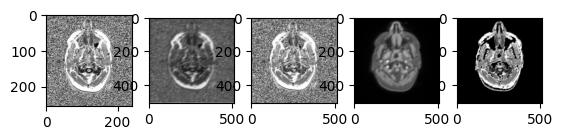

In [35]:
#view slice of inv2, original t1map, mask,
slice_idx = 5

print(t1map_3d.size())

plt.subplot(1, 5, 1)
#display original t1map image
plt.imshow(t1map_3d[slice_idx].squeeze(0), cmap="gray")
plt.subplot(1, 5, 2)
#display a slice of t1map mask
plt.imshow(t1map_mask3d[slice_idx].cpu(), cmap="gray")
plt.subplot(1, 5, 3)
#display a slice from t1map edited with t1map mask
plt.imshow(edited_t1map_3d_from_t1map[slice_idx].squeeze(0), cmap="gray")
plt.subplot(1, 5, 4)
#display a slice of inv2 mask
plt.imshow(inv2_mask3d[slice_idx].cpu(), cmap="gray")
plt.subplot(1, 5, 5)
#display a slice from t1map edited with inv2 mask
plt.imshow(edited_t1map_3d_from_inv2[slice_idx].squeeze(0), cmap="gray")

print(edited_t1map_3d_from_inv2[5, 75, 75], torch.min(edited_t1map_3d_from_inv2))

## save edited images
Save edited t1map images back as their original DICOM files

In [ ]:
#edit dicom file and save based on inv2 mask
for edit_slice_idx in range(edited_t1map_3d_from_inv2.size(0)):
    # Get the original dataset for the slice
    original_dataset = dataset[edit_slice_idx][5] # Assuming index 5 is the t1map_info object

    # Create a new dataset object with the same metadata
    new_dataset = pydicom.Dataset()
    for data_element in original_dataset:
        if data_element.tag != pydicom.tag.Tag(0x7fe0, 0x0010): # Exclude the original PixelData tag
            new_dataset[data_element.tag] = data_element

    # Add the modified pixel data
    # Ensure the data type is appropriate for DICOM (e.g., int16 or uint16)
    # You might need to scale/cast the tensor data
    modified_pixel_data = edited_t1map_3d_from_inv2[edit_slice_idx].squeeze(0).numpy().astype('int16') # Example cast to int16

    new_dataset.PixelData = modified_pixel_data.tobytes()
    new_dataset.Rows, new_dataset.Columns = modified_pixel_data.shape

    # Add FileMetaInformation if it exists in the original dataset
    if hasattr(original_dataset, 'file_meta'):
        new_dataset.file_meta = original_dataset.file_meta

    # Save the new DICOM file
    new_dataset.save_as(f'./lemon_data/edited_t1map/edited_t1map_{edit_slice_idx}.dcm')

print("DICOM files saved successfully.")